In [1]:
import numpy as np
import logging
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import heart_disease.plotting as hdp
import heart_disease.preprocessing as hdpp
import heart_disease.parameter_optimization as hdpo
from heart_disease.globals import data_path, output_path

import seaborn as sns
import pandas as pd
from copy import deepcopy as cp
%load_ext autoreload

from heart_disease.globals import code_path, raw_data_path, data_path, output_path

%autoreload 2

In [2]:
LOG_FMT = '%(asctime)s|%(name)s|%(levelname)s|%(message)s'
logging.basicConfig(level=logging.DEBUG, format=LOG_FMT)
logger = logging.getLogger(__name__)

In [3]:
# Get Metadata
meta_data_df = pd.read_csv(data_path+'meta_data.csv')
meta_data_df.head()

,name,datatype,description,id
0,age,numeric,age in years,3
1,sex,bool,sex (1 = male; 0 = female),4
2,cp,categorical,chest pain type\r -- Value 1: typical angina...,9
3,trestbps,numeric,resting blood pressure (in mm Hg on admission ...,10
4,chol,numeric,serum cholestoral,12


In [4]:
# Import Raw Data
data_file_name_str = 'train_validation.cleveland.csv'
data_df = hdpp.load_data(data_path+data_file_name_str)
data_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,ispos_truth
pat_id,,,,,,,,,,,,,,
162,54.0,0.0,3.0,110.0,214.0,0.0,0.0,158.0,0.0,1.6,2.0,0.0,3.0,False
18,48.0,0.0,3.0,130.0,275.0,0.0,0.0,139.0,0.0,0.2,1.0,0.0,3.0,False
100,45.0,1.0,4.0,115.0,260.0,0.0,2.0,185.0,0.0,0.0,1.0,0.0,3.0,False
78,48.0,1.0,2.0,130.0,245.0,0.0,2.0,180.0,0.0,0.2,2.0,0.0,3.0,False
262,60.0,0.0,1.0,150.0,240.0,0.0,0.0,171.0,0.0,0.9,1.0,0.0,3.0,False


In [5]:
clean_df = hdpp.DataCleaner(data_path+'meta_data.csv').get_clean_dataframe(data_df)

In [6]:
clean_df.head()

,age,trestbps,chol,thalach,oldpeak,sex,fbs,exang,cp_is1,cp_is2,...,slope_is1,slope_is2,slope_is3,ca_is0,ca_is1,ca_is2,ca_is3,thal_is3,thal_is6,thal_is7
0,-0.056774,-1.287754,-0.616740,0.327936,0.449032,-1.467235,-0.426956,-0.667727,-0.293470,-0.412436,...,-0.944281,1.107019,-0.29347,0.856052,-0.531494,-0.405096,-0.256374,0.919526,-0.225668,-0.833085
1,-0.717684,-0.115660,0.517089,-0.503080,-0.715885,-1.467235,-0.426956,-0.667727,-0.293470,-0.412436,...,1.059007,-0.903327,-0.29347,0.856052,-0.531494,-0.405096,-0.256374,0.919526,-0.225668,-0.833085
2,-1.048139,-0.994731,0.238279,1.508854,-0.882301,0.681554,-0.426956,-0.667727,-0.293470,-0.412436,...,1.059007,-0.903327,-0.29347,0.856052,-0.531494,-0.405096,-0.256374,0.919526,-0.225668,-0.833085
3,-0.717684,-0.115660,-0.040532,1.290165,-0.715885,0.681554,-0.426956,-0.667727,-0.293470,2.424621,...,-0.944281,1.107019,-0.29347,0.856052,-0.531494,-0.405096,-0.256374,0.919526,-0.225668,-0.833085
4,0.604136,1.056434,-0.133469,0.896526,-0.133427,-1.467235,-0.426956,-0.667727,3.407508,-0.412436,...,1.059007,-0.903327,-0.29347,0.856052,-0.531494,-0.405096,-0.256374,0.919526,-0.225668,-0.833085


In [8]:
algorithum_list = hdpo.algorithum_list

In [9]:
algorithum_list

['SVC', 'SVC_poly', 'GM', 'Perceptron_PCA', 'Perceptron_LDA']

In [10]:
algorithum = algorithum_list[0]

In [11]:
reduced_frame_list =[]

cols2keep = ["mean_test_score","std_test_score","mean_train_score", "std_train_score","params"]

# TODO: make PCA / No PCA, LDA categorical

for algorithum in algorithum_list:
    results_df = pd.read_pickle(output_path + algorithum + '.grid_search.pkl' )
    results_df = results_df.loc[:, cols2keep]
    results_df['algorithum']=algorithum
    # ad-hoc algorithum specific Processing
    if algorithum == 'SVC_poly':
        results_df['params'].apply(lambda x: x.update({'classifier__kernel':'poly'}))
    
    reduced_frame_list.append(results_df)
    
summary_df = pd.concat(reduced_frame_list)

In [12]:
print(summary_df[summary_df['algorithum']=='SVC_poly'].loc[0,'params'])

{'classifier__C': 0.1, 'classifier__degree': 2, 'classifier__gamma': 9.9999999999999995e-07, 'feature__n_components': 0, 'classifier__kernel': 'poly'}


In [13]:
summary_df['sigma_low_test_score'] = summary_df['mean_test_score'] - summary_df['std_test_score']
summary_df['sigma_low_train_score'] = summary_df['mean_train_score'] - summary_df['std_train_score']
summary_df['sigma_low_diff'] = summary_df['sigma_low_train_score'] - summary_df['sigma_low_test_score']
summary_df.head()

,mean_test_score,std_test_score,mean_train_score,std_train_score,params,algorithum,sigma_low_test_score,sigma_low_train_score,sigma_low_diff
0,0.829474,0.041965,0.885412,0.013932,"{'classifier__C': 0.1, 'classifier__gamma': 1e...",SVC,0.787509,0.871480,0.083971
1,0.838596,0.047595,0.847529,0.018670,"{'classifier__C': 0.1, 'classifier__gamma': 1e...",SVC,0.791001,0.828859,0.037858
2,0.847719,0.046209,0.848706,0.013364,"{'classifier__C': 0.1, 'classifier__gamma': 1e...",SVC,0.801510,0.835342,0.033832
3,0.847018,0.038603,0.865412,0.013134,"{'classifier__C': 0.1, 'classifier__gamma': 1e...",SVC,0.808415,0.852277,0.043863
4,0.845614,0.046017,0.870353,0.015561,"{'classifier__C': 0.1, 'classifier__gamma': 1e...",SVC,0.799597,0.854791,0.055195


In [14]:
summary_df['params'].iloc[0]

{'classifier__C': 0.1,
 'classifier__gamma': 9.9999999999999995e-07,
 'classifier__kernel': 'linear',
 'feature__n_components': 0}

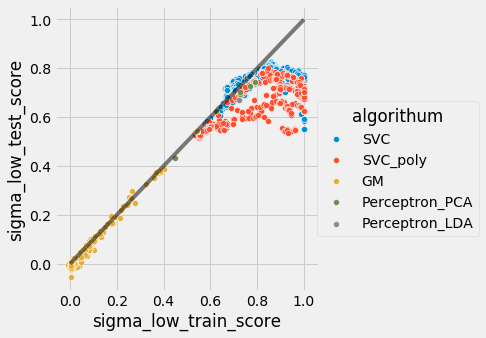

In [15]:
sns.pairplot(x_vars=["sigma_low_train_score"], y_vars=["sigma_low_test_score"], data=summary_df, hue="algorithum", size=5)
plt.plot([0,1],[0,1],c='k',alpha=0.5)
plt.show()

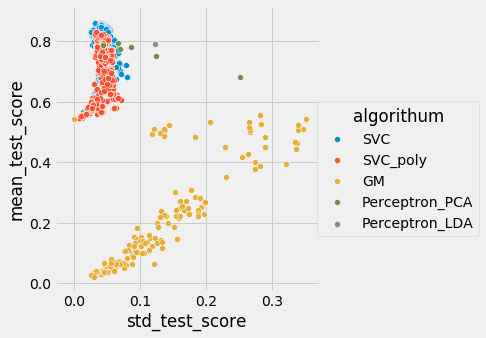

In [16]:
sns.pairplot(x_vars=["std_test_score"], y_vars=["mean_test_score"], data=summary_df, hue="algorithum", size=5)
plt.show()

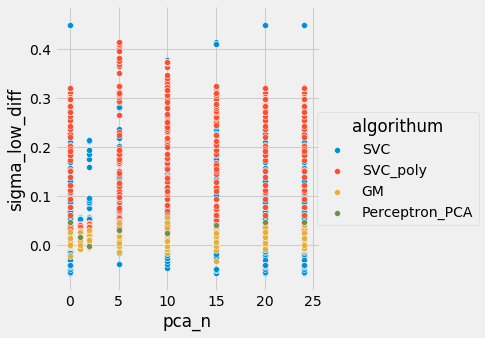

In [17]:
mod_df = cp(summary_df)
mod_df['pca_n'] = mod_df['params'].apply(lambda x: x.get('feature__n_components',np.nan))
mod_df = mod_df[~mod_df['pca_n'].isnull()]
sns.pairplot(x_vars=["pca_n"], y_vars=['sigma_low_diff'], data=mod_df, hue="algorithum", size=5)
plt.show()

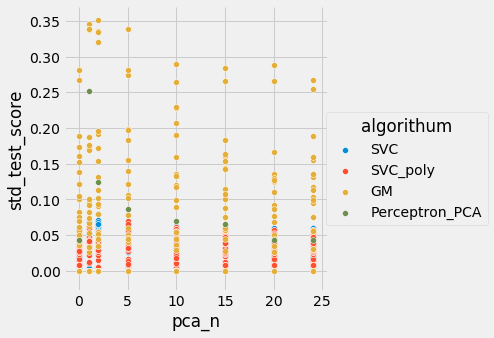

In [18]:
mod_df = cp(summary_df)
mod_df['pca_n'] = mod_df['params'].apply(lambda x: x.get('feature__n_components',np.nan))
mod_df = mod_df[~mod_df['pca_n'].isnull()]
sns.pairplot(x_vars=["pca_n"], y_vars=["std_test_score"], data=mod_df, hue="algorithum", size=5)
plt.show()

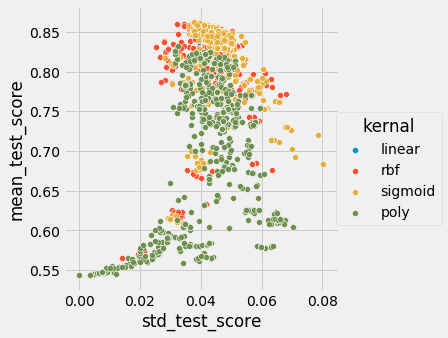

In [19]:
mod_df = cp(summary_df)
mod_df['kernal'] = mod_df['params'].apply(lambda x: x.get('classifier__kernel',np.nan))
mod_df = mod_df[~mod_df['kernal'].isnull()]
sns.pairplot(x_vars=["std_test_score"], y_vars=["mean_test_score"], data=mod_df, hue="kernal", size=5)
plt.show()

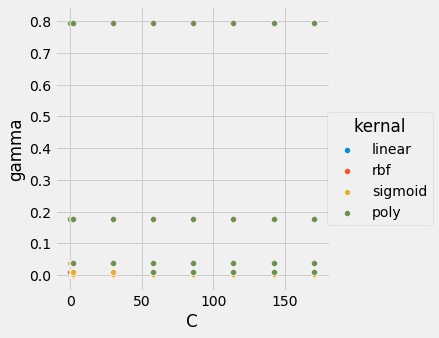

In [20]:
mod_df = cp(summary_df)
mod_df['kernal'] = mod_df['params'].apply(lambda x: x.get('classifier__kernel',np.nan))
mod_df['C'] = mod_df['params'].apply(lambda x: x.get('classifier__C',np.nan))
mod_df['gamma'] = mod_df['params'].apply(lambda x: x.get('classifier__gamma',np.nan))

mod_df = mod_df[~mod_df['kernal'].isnull()]
mod_df = mod_df[mod_df['mean_test_score']> 0.8]
sns.pairplot(x_vars=["C"], y_vars=["gamma"], data=mod_df, hue="kernal", size=5)
plt.show()

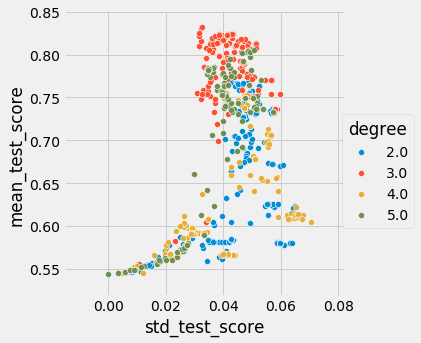

In [28]:
mod_df = cp(summary_df)
mod_df['degree'] = mod_df['params'].apply(lambda x: x.get('classifier__degree',np.nan))

sns.pairplot(x_vars=["std_test_score"], y_vars=["mean_test_score"], data=mod_df, hue="degree", size=5)
plt.show()

In [21]:
c_curve = mod_df.groupby('C').agg({'sigma_low_test_score':np.max}).reset_index()
gamma_curve = mod_df.groupby('gamma').agg({'sigma_low_test_score':np.max}).reset_index()

In [22]:
[0.0, 1] + list(np.linspace(2, 170/2, 8))

[0.0,
 1,
 2.0,
 13.857142857142858,
 25.714285714285715,
 37.571428571428569,
 49.428571428571431,
 61.285714285714292,
 73.142857142857139,
 85.0]

In [23]:
[0.0, 1] + list(np.linspace(2, 85, 5))

[0.0, 1, 2.0, 22.75, 43.5, 64.25, 85.0]

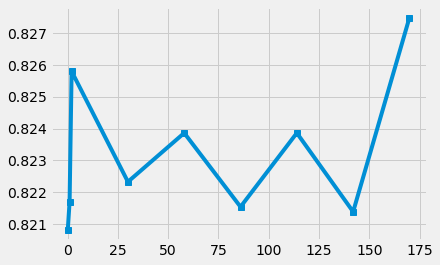

In [24]:
plt.plot(c_curve['C'],c_curve['sigma_low_test_score'],marker='s')
plt.show()

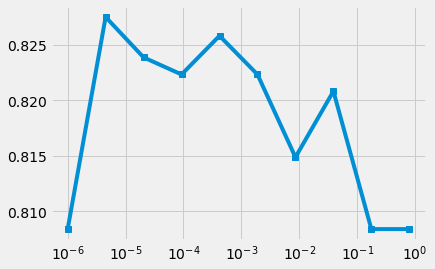

In [25]:
plt.semilogx(gamma_curve['gamma'],gamma_curve['sigma_low_test_score'],marker='s')
plt.show()